## Subduction Zone

In [3]:
# packages
import torch
import pandas as pd
import pygsig.datasets.subduction
from pygsig.datasets.subduction import SubductionZone
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

In [4]:
# Download data
poly_path='datasets/subduction/polygon_large.geojson' # region of interest
rast_path='datasets/subduction/interface.grd' # interface data
data_path='datasets/subduction/site_data_large.geojson' # earthquake data
site_path='datasets/subduction/site_location_large.geojson' # site data
label_path='datasets/subduction/nonlinear.json'
start_date=pd.Timestamp('2008-01-01 11:59:00+0000', tz='UTC')
end_date=pd.Timestamp('2023-12-31 11:59:00+0000', tz='UTC')
dataset = SubductionZone(poly_path=poly_path,
                         rast_path=rast_path,
                         label_path=label_path,
                         data_path=data_path,
                         site_path=site_path,
                         start_date=start_date, end_date=end_date,redownload=False)

In [10]:
# Load data
seq_data = dataset.load_data(task_name='depth',k=4, bandwidth = 100e3)

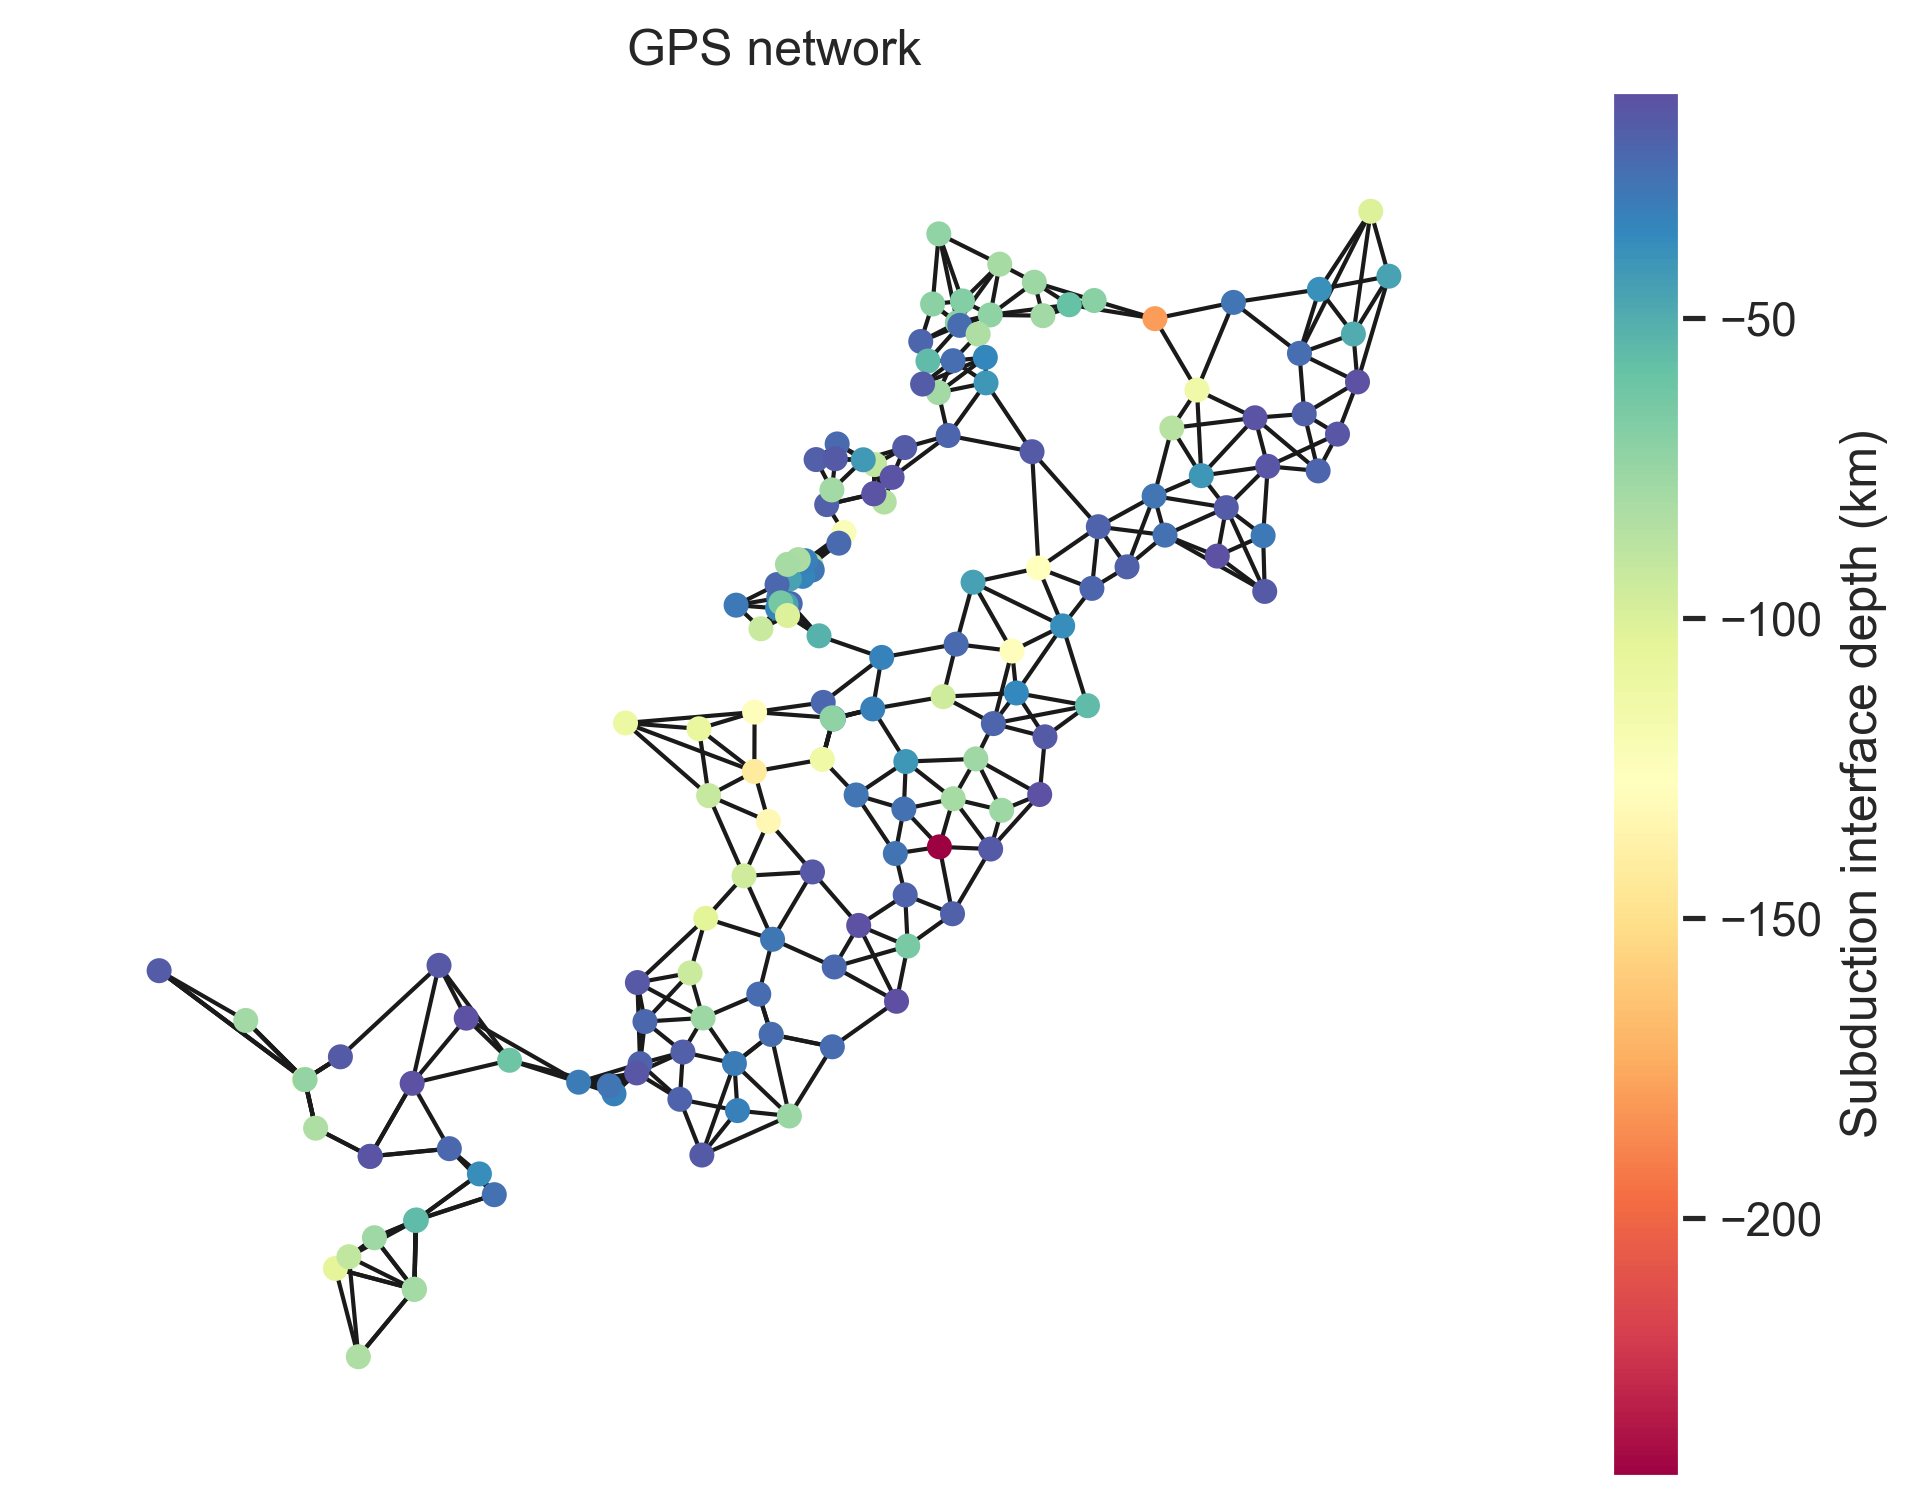

In [22]:
data = seq_data[0]
G = nx.Graph()
G.add_edges_from(data.edge_index.T.tolist())
pos = data.pos.numpy()[:,:2]
depth = seq_data.y*1e-3


plt.figure(figsize=(8, 6),dpi=300)
nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=depth, cmap='Spectral')
nx.draw_networkx_edges(G, pos=pos)
plt.title('GPS network')
plt.axis('off')

cmap = plt.cm.Spectral
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(depth)
cbar = plt.colorbar(sm,ax=plt.gca())
cbar.set_label('Subduction interface depth (km)')
plt.show()



Model: GCNRegression
Number of parameters: 7809


100%|██████████| 40/40 [00:09<00:00,  4.16it/s]

MSE: 0.6984 ± 0.3476, MAE: 0.6015 ± 0.1530 


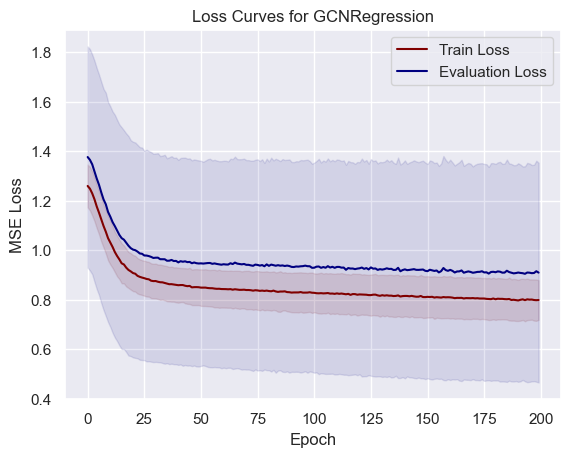

Model: ChebNetRegression
Number of parameters: 7809


100%|██████████| 40/40 [00:06<00:00,  6.37it/s]


MSE: 0.7778 ± 0.3400, MAE: 0.6801 ± 0.1515 


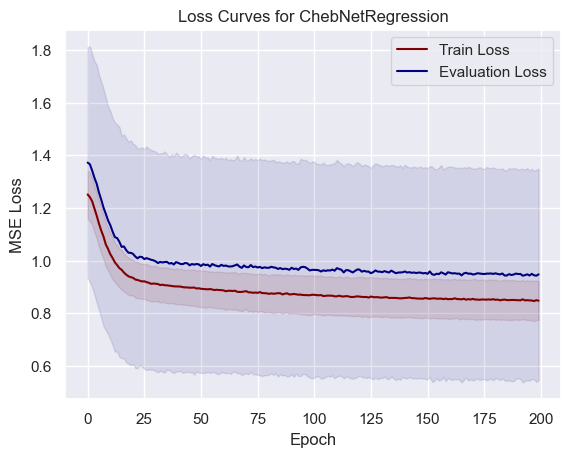

Model: ChebNetRegression
Number of parameters: 15553


100%|██████████| 40/40 [00:13<00:00,  3.06it/s]

MSE: 0.7162 ± 0.3458, MAE: 0.6208 ± 0.1585 


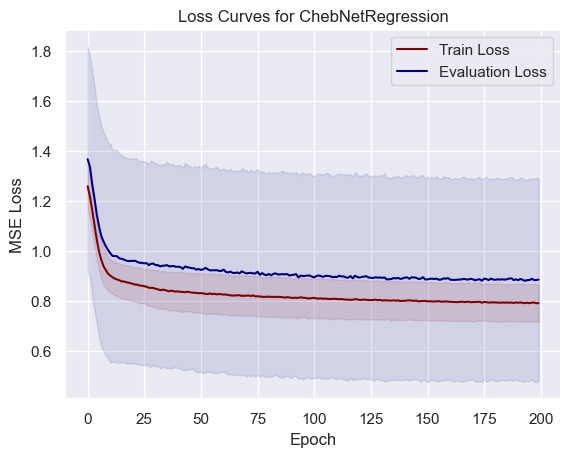

Model: ChebNetRegression
Number of parameters: 23297


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]

MSE: 0.6620 ± 0.3268, MAE: 0.5746 ± 0.1377 


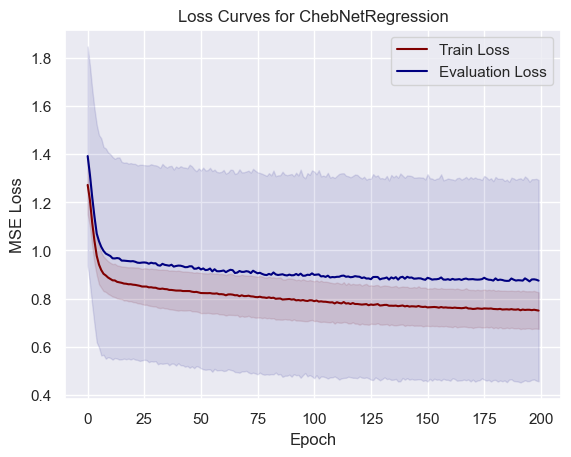

Model: ChebNetRegression
Number of parameters: 31041


100%|██████████| 40/40 [00:26<00:00,  1.53it/s]

MSE: 0.6358 ± 0.2968, MAE: 0.5536 ± 0.1149 


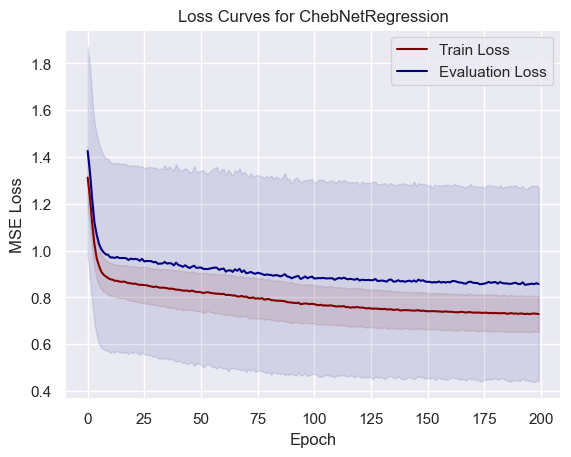

Model: MLPRegression
Number of parameters: 7809


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


MSE: 0.7780 ± 0.3389, MAE: 0.6810 ± 0.1502 


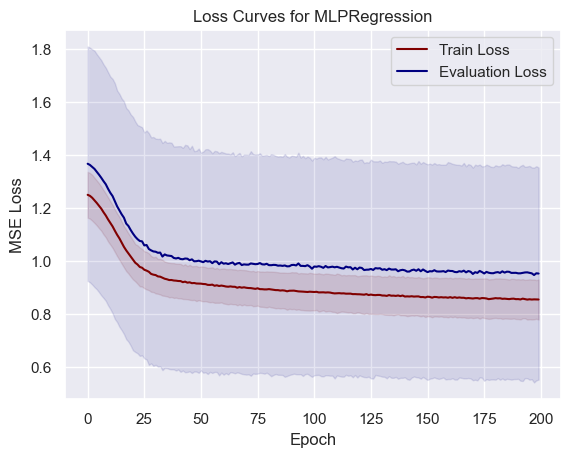

In [30]:
import torch
import torch.nn as nn
import signatory
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T

from sklearn.preprocessing import StandardScaler


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNRegression, MLPRegression, ChebNetRegression
from pygsig.graph import StaticGraphTemporalSignal, split_nodes
from pygsig.signature import SignatureFeatures

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

signature_depth = 4


signature_transform = SignatureFeatures(sig_depth=signature_depth, normalize=True, log_signature=False,augment=False)
data = signature_transform(seq_data)

scaler = StandardScaler()
data.y = torch.tensor(scaler.fit_transform(data.y.unsqueeze(-1)),dtype=torch.float) # patch TODO fix this in subduction.py

num_nodes = data.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200

learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

# initialize models
models = []
models += [GCNRegression(num_channels=[data.num_node_features, num_hidden, 1])]
models += [ChebNetRegression(num_channels=[data.num_node_features, num_hidden, 1], K=k) for k in [1,2,3,4]]
models += [MLPRegression(num_channels=[data.num_node_features, num_hidden, 1])]

mse_models = []
mae_models = []

for model in models:
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso)
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    mse = np.zeros([num_splits, num_trials])
    mae = np.zeros([num_splits, num_trials])

    with tqdm(total=num_splits*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits, seed=31)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # train
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    train_loss = criterion(out[train_mask], data.y[train_mask])
                    train_loss.backward()
                    optimizer.step()
                    # evaluate
                    model.eval()
                    with torch.no_grad():
                        eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                        train_losses[split, trial, epoch] = train_loss.item()
                        eval_losses[split, trial, epoch] = eval_loss.item()
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Test MSE Loss: {eval_loss.item():.4f}')
                pbar.update(1)
                with torch.no_grad():
                    out = model(data.x, data.edge_index)
                    mse[split,  trial] = mean_squared_error(data.y[test_mask], out[test_mask])
                    mae[split, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])

    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f} ')  
    mse_models.append(mse)
    mae_models.append(mae)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1))
    avg_eval_losses = np.mean(eval_losses, axis=(0,1))
    std_train_losses = np.std(train_losses, axis=(0,1))
    std_eval_losses = np.std(eval_losses, axis=(0,1))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses,  label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1,color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Loss Curves for {model._get_name()}')
    plt.legend()
    plt.show()

In [31]:
MSE = np.array(mse_models)
MAE = np.array(mae_models)

In [32]:
mse_base = []
mae_base = []
with torch.no_grad():
    mse_split = []
    mae_split = []
    for split in range(num_splits):
        train_indices, _, test_indices = splits[split]
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        mse_trial = []
        mae_trial = []
        for trial in range(num_trials):
            # Baseline
            out = torch.mean(data.y[train_mask]).item() * torch.ones(data.num_nodes)
            mse_trial.append( mean_squared_error(data.y[test_mask],out[test_mask]) )
            mae_trial.append( mean_absolute_error(data.y[test_mask],out[test_mask]) )
        mse_split.append(mse_trial)
        mae_split.append(mae_trial)
    mse_base.append(mse_split)
    mae_base.append(mae_split)
        

print('Model: Baseline')
print(f'Number of prameters: {0}')
print(f'{np.mean(mse_base):.4f} ± {np.std(mse_base):.4f}, MAE: {np.mean(mae_base):.4f} ± {np.std(mae_base):.4f} ')  


Model: Baseline
Number of prameters: 0
0.9323 ± 0.3133, MAE: 0.8491 ± 0.1038 


In [33]:
MSE = np.concatenate([MSE,np.array(mse_base)],axis=0)
MAE = np.concatenate([MAE,np.array(mae_base)],axis=0)

/var/folders/0b/l3krx7155s56x0pllytjm6dc0000gn/T/ipykernel_62187/937441656.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis1.set_xticklabels(model_names, rotation=45, ha='right')  # Set the x-axis tick labels
/var/folders/0b/l3krx7155s56x0pllytjm6dc0000gn/T/ipykernel_62187/937441656.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis2.set_xticklabels(model_names, rotation=45, ha='right')  # Set the x-axis tick labels


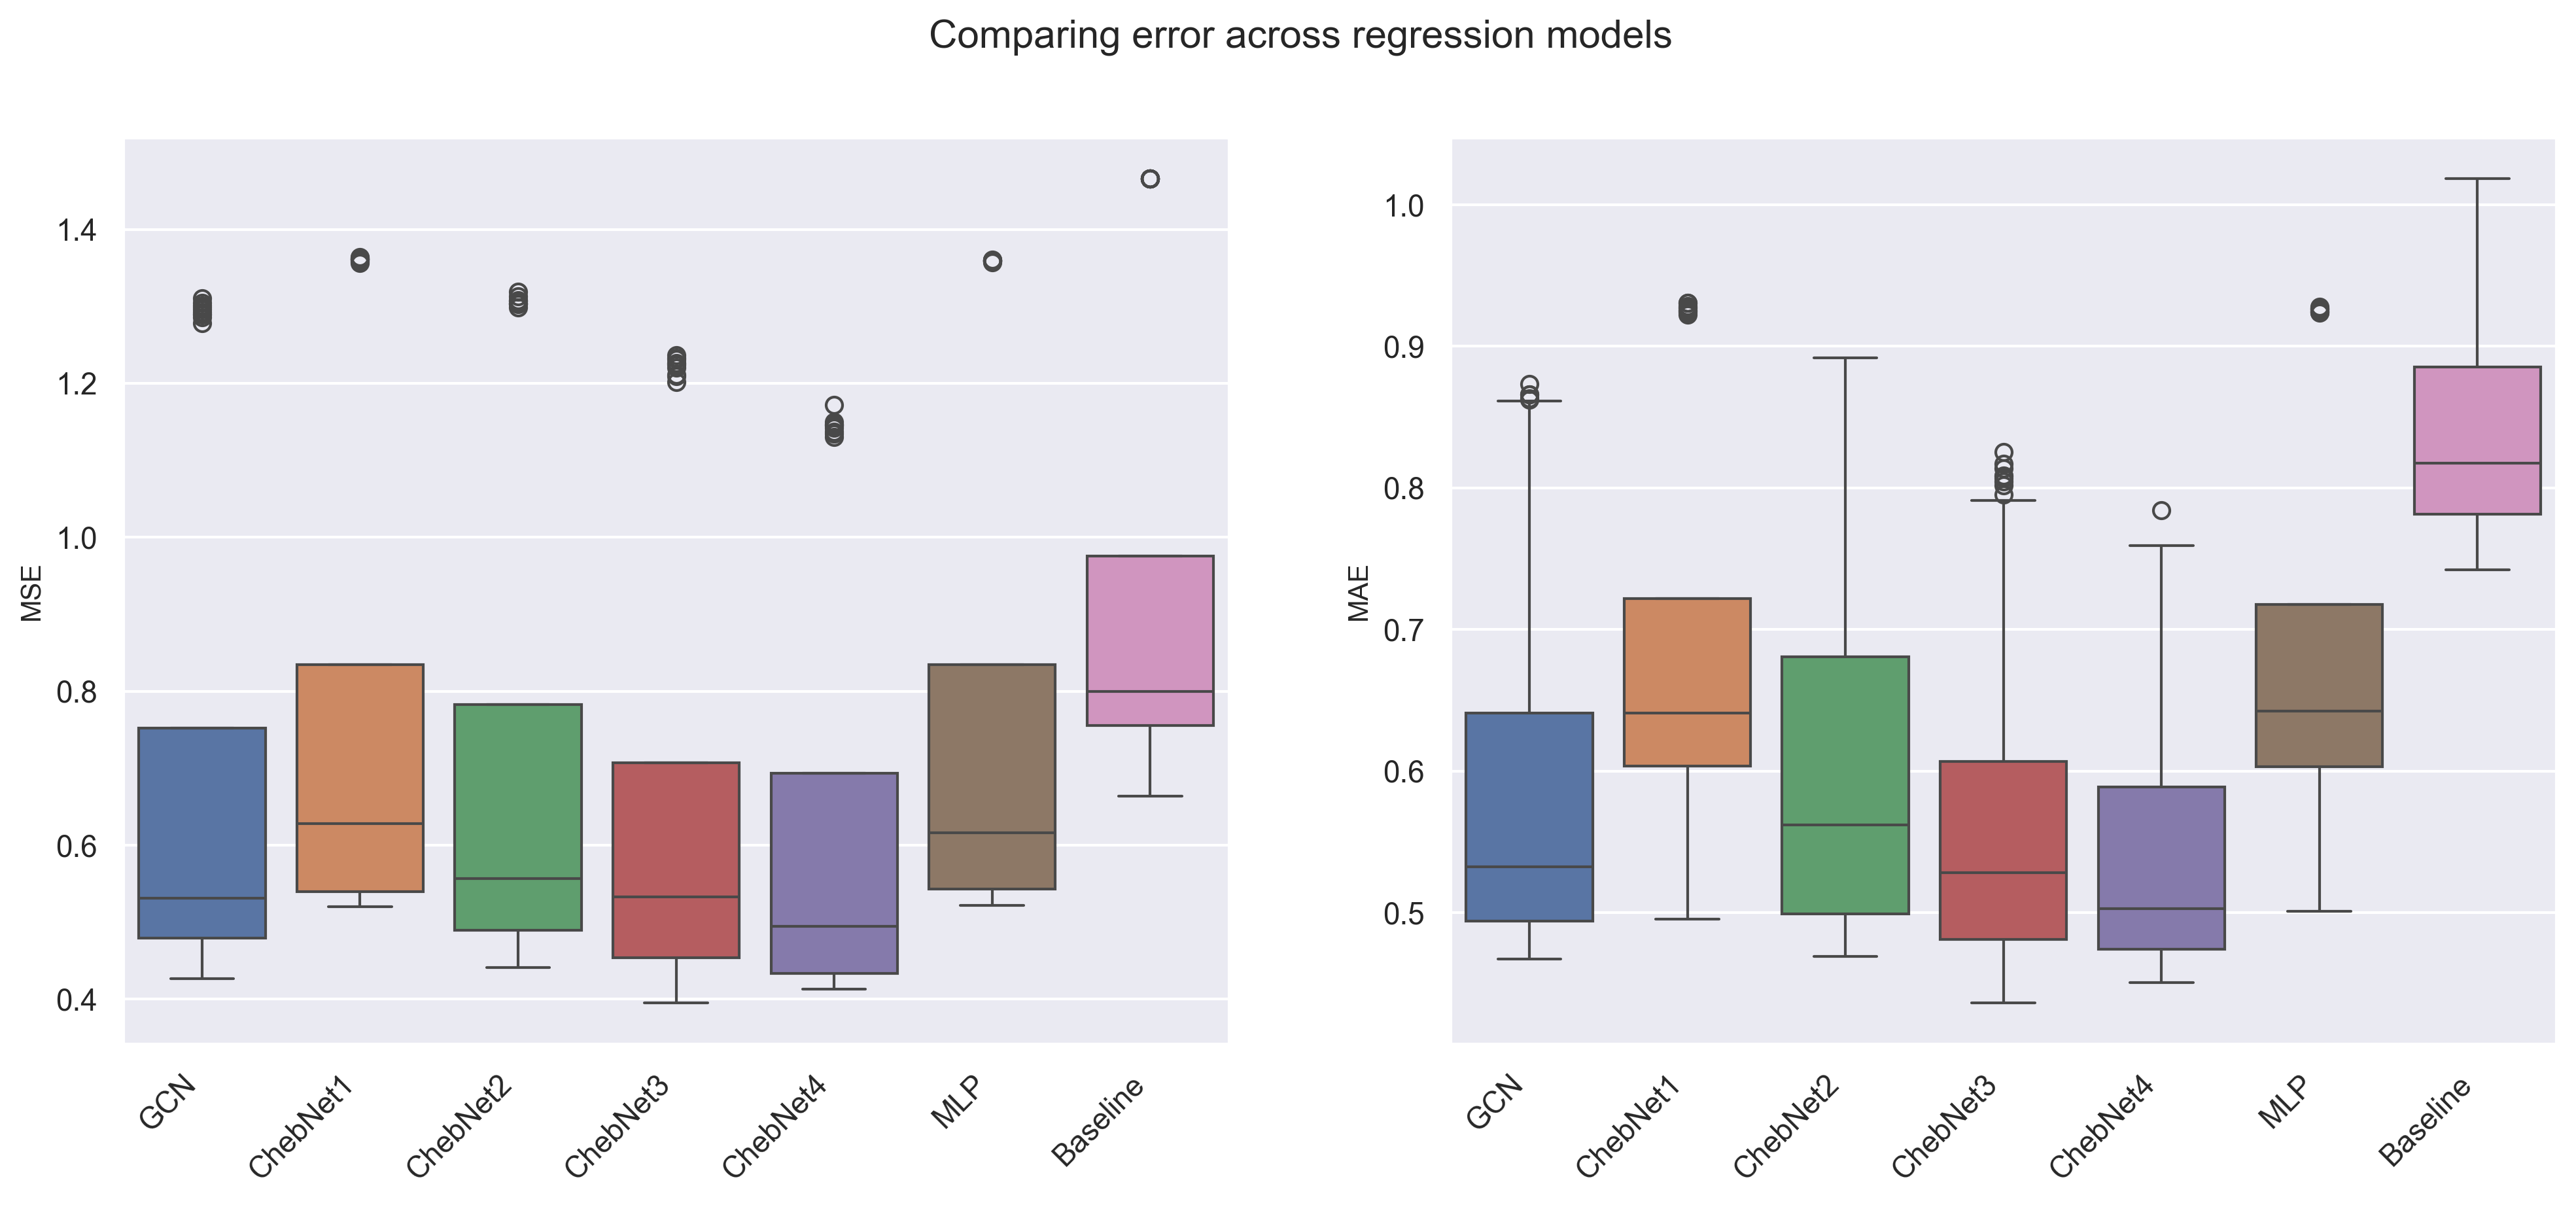

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

model_names = [ 'GCN','ChebNet1','ChebNet2','ChebNet3','ChebNet4', 'MLP', 'Baseline']

box_mse = np.reshape(MSE,(-1,num_splits*num_trials))
box_mae = np.reshape(MAE,(-1,num_splits*num_trials))

# Set the seaborn theme
sns.set_theme(style="darkgrid")

# Create subplots with 1 row and 2 columns
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(16, 6),dpi=300)

# Plot MSE
sns.boxplot(data=[box_mse[i] for i in range(len(model_names))], ax=axis1)
axis1.set_ylabel('MSE', fontsize=10)  # Set the font size for the y-axis label
axis1.set_xticklabels(model_names, rotation=45, ha='right')  # Set the x-axis tick labels

# Plot MAE
sns.boxplot(data=[box_mae[i] for i in range(len(model_names))], ax=axis2)
axis2.set_ylabel('MAE', fontsize=10)  # Set the font size for the y-axis label
axis2.set_xticklabels(model_names, rotation=45, ha='right')  # Set the x-axis tick labels

fig.suptitle('Comparing error across regression models')
plt.show()